In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
from astropy.io import fits

In [3]:
corrected_path = '../Rand_Ha/'
table_path = '../tables/'
cat_path = '../CANDLES_data/goods_catalogs/'
total_path = '../total_gal/'
cutout_path = '../CANDLES_data/total_cutouts/'
save_cutout_path = '../CANDLES_data/merger_cutouts/'
seg_path = '../CANDLES_data/goodsn_3dhst_v4.0_f160w/'
Ha_path = '../merger_candidates/'
image_path = '../images/'

# Segmentation Mapping
To plot images of galaxy mergers, we must first know where one galaxy ends and another begins. This is done through the use of segmentations maps. These maps are matrices that define every pixel as a galactic ID (or not for where there is no object).

In [4]:
merger_cat = pd.read_pickle(table_path+'merger_cat.plk')

#Opening the segmentation Maps
seg_N = fits.open(seg_path+'goodsn_3dhst.v4.0.F160W_seg.fits')[0].data
seg_S = fits.open(seg_path+'goodss_3dhst.v4.0.F160W_seg.fits')[0].data
img_N = fits.open(seg_path+'goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].data
img_S = fits.open(seg_path+'goodss_3dhst.v4.0.F160W_orig_sci.fits')[0].data

In [5]:
def Scaling_factor(X, m, M):              #X = Counts, m = Vmin, M = Vmax
    """
    Our filter function
    ----------
    X : `~numpy.ndarray` The array we are trying to filter
    m : Our lower bound
    M : Our Upper bound
    -------
    """
    m_mask = np.zeros_like(X)
    M_mask = np.zeros_like(X)

    for i in range(len(X)):
        for ii in range(len(X[0])):
            if X[i][ii] <= m:
                m_mask[i][ii] = 1 
            
            if X[i][ii] >= M:
                M_mask[i][ii] = 1 
             
    scl_img =  np.arcsinh(X - m)/np.arcsinh(M - m)
            
    for i in range(len(X)):
        for ii in range(len(X[0])):
            if m_mask[i][ii] == 1:
                scl_img[i][ii] = 0
            if M_mask[i][ii] == 1:
                scl_img[i][ii] = 1
            
    return scl_img

Now we want to make an image that only has the galaxy and its identified mergers cropped within it.

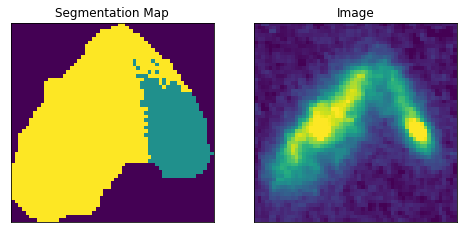

In [7]:
rows = []
cols = []
gal_ids = []
idx = 20      #The ID we are selecting from the Merging Table.

for i in range(len(merger_cat['GN1']['ids'])):
    temp = []
    #Mergers = ast.literal_eval(GN1_Merging_Table.mergers.values[i])
    temp = np.concatenate((merger_cat.GN1.ids[i],merger_cat.GN1.mergers[i]),axis=None).tolist()
    gal_ids.append(temp)

#for j in range(len(gal_ids)):
#    idx = j               
               
for g in (gal_ids[idx]):
    locations= np.argwhere(seg_N == g).T
    rows.extend(locations[0])
    cols.extend(locations[1])

rowmin = min(rows)
rowmax = max(rows)
colmin = min(cols)
colmax = max(cols)
segsize = seg_N[rowmin : rowmax+1, colmin : colmax+1]
newseg = np.zeros_like(segsize)

for i in range(len(gal_ids[idx])):
    for j in range(len(segsize)):
        for k in range(len(segsize[j])):
            if segsize[j][k] == gal_ids[idx][i]:
                newseg[j][k] = i + 1
                
m=np.percentile(img_N[rowmin : rowmax +1, colmin : colmax+1],1.5)
M=np.percentile(img_N[rowmin : rowmax +1, colmin : colmax+1],98.5)
if M < np.abs(m)*6:
    M = np.abs(m)*6

gal_img = Scaling_factor(img_N[rowmin : rowmax +1, colmin : colmax+1], m, M)

#plotting the image                
plt.figure(figsize = [8,5])
plt.subplot(121)
plt.title("Segmentation Map")
plt.xticks([])
plt.yticks([])
plt.imshow(newseg,cmap = 'viridis')
    
plt.subplot(122)
plt.title("Image")
plt.xticks([])
plt.yticks([])
plt.imshow(gal_img,vmin = 0, vmax = 1 ,cmap = 'viridis')